## Install packages

* torch: an open-source machine learning package for Python. Provides a flexible framework for neural network development and training.

* torchvision: Offers tools and utilities for dealing with computer vision problems.

In [1]:
!pip install torch
!pip install torchvision

## Import essential packages

We'll now import the packages required to execute the project properly.
These are Python packages/modules that are often used for different purposes in deep learning, data manipulation, visualization, and evaluation.

* os: Provides access to functions specific to your operating system.
  
* torch nn: This module, when used with PyTorch, makes it easier to build neural network architectures.

* torch.nn.functional: Provides a set of functions helpful for neural network operations that may be applied to tensors.
  
* torch.optim: The optimization algorithms in this module are used to optimize neural network parameters during training.
  
* Torchvision: Contains model architectures, image transformations, and commonly used datasets for computer vision applications.
  
* PIL (Python Imaging Library): allows for opening, editing, and saving many picture file formats.  

* transforms: Provides common image transformations such as scaling, cropping, and normalizing for preprocessing purposes.

* datasets: Provides the ability to download and load popular datasets.

* ImageFolder: Enables the development of a dataset composed of photographs arranged into folders, each representing a class.

* DataLoader: Creates iterable data loaders for training and evaluation, allowing for batch data loading.

* Pandas: A robust Python data processing package. Provides functions and data structures for handling time series data and numerical tables.
  
* NumPy: a key Python package for scientific computing. Large, multi-dimensional arrays and matrices are supported, and a variety of mathematical operations may be performed on them.

* zipfile: Enables writing, reading, listing, appending, and creating ZIP files.
  
* Seaborn is a Matplotlib-based library for data visualization. Provides a powerful drawing tool for producing appealing and statistical visualizations.
  
* matplotlib.pyplot: Provides an interface for creating plots and visualizations comparable to MATLAB.data in batches.

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
import torch.optim as optim
from torch.optim import SGD, Adam
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
import zipfile
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,  precision_recall_curve, classification_report, accuracy_score, auc
import seaborn as sns
import matplotlib.pyplot as plt

## Import the dataset and resize the images

In the beginning, we have two possibilities for retrieving the dataset: upload it from our local files and give the right path, or use Kaggle to retrieve it. Once the dataset is accessible, we begin image preprocessing. 
We start by defining transformations for preprocessing the images. These steps involve scaling each image to a standard size of 180 × 180 pixels and applying normalization. Normalization sets the pixel values to have a mean of 0.5 and a standard deviation of 0.5 in each color channel, guaranteeing similar data qualities.  

In [3]:
# Define transforms for preprocessing
# Resizing the images to 180 x 180
resize_transform = transforms.Resize((180, 180))
tensor_transform = transforms.ToTensor()
# Normalize the pixel values to have a mean of 0.5 and a standard deviation of 0.5
normalize_transform = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# Combine transformations
transform = transforms.Compose([
    resize_transform,
    tensor_transform,
    normalize_transform
])

In [4]:
# Load image data
data_dir = 'C:/Users/DELL/Downloads/archive/data'
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [5]:
# !pip install kaggle
# from google.colab import files
# files.upload()  # Select the kaggle.json file from your local machine

In [6]:
# Move the API key to the required location
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
# !kaggle datasets download -d mahmoudreda55/satellite-image-classification

# Unzip the dataset
# with zipfile.ZipFile('/content/satellite-image-classification.zip', 'r') as zip_ref:
 #    zip_ref.extractall('/content')

# List the contents of the extracted folder
# !ls content

In [7]:
# Define the path to your dataset folder
# data_dir = '/content/data'

# Load the dataset using ImageFolder
# dataset = datasets.ImageFolder(data_dir, transform=transform)

#### Custom class ImageGenreDataset: 
A unique dataset class is created to handle image data organized by category. It loads images from a specified directory, assigns each one a number label dictated by the category folders, and allows you to make optional image adjustments. This class may be used in conjunction with PyTorch's DataLoader to facilitate training and assessment for image categorization tasks.  

In [8]:
class ImageGenreDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []  # List to store paths of all images
        self.labels = []       # List to store corresponding labels

        # Get the list of genre folders in the root directory
        genre_folders = os.listdir(root_dir)

        # Assign a label to each genre folder
        for label, genre_folder in enumerate(genre_folders):
            genre_path = os.path.join(root_dir, genre_folder)
            image_files = os.listdir(genre_path)

            # Append image paths and corresponding labels to lists
            self.image_paths.extend([os.path.join(genre_path, img) for img in image_files])
            self.labels.extend([label] * len(image_files))

    def __len__(self):
        # Return the total number of images in the dataset.
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Retrieve an image and its label at the specified index.
        # Returns tuple: A tuple containing the image and its label.
      
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open the image and convert it to RGB format
        img = Image.open(img_path).convert('RGB')

        # Apply any specified transformations to the image
        if self.transform:
            img = self.transform(img)

        return img, label

# Testing the custom dataset
custom_dataset = ImageGenreDataset(data_dir, transform=transform)
print("Custom Dataset Length:", len(custom_dataset))

# Get a sample image and its label
sample_img, sample_label = custom_dataset[0]
print("Sample Image Shape:", sample_img.shape)
print("Sample Label:", sample_label)

Custom Dataset Length: 5631
Sample Image Shape: torch.Size([3, 180, 180])
Sample Label: 0


In [9]:
# Calculates the number of classes and retrieves their names from the dataset for analysis
num_classes = len(dataset.classes)
class_names = dataset.classes

print("Number of classes:", num_classes)
print("Class names:", class_names)

Number of classes: 4
Class names: ['cloudy', 'desert', 'green_area', 'water']


In [10]:
# Calculate total number of images from the dataset
num_images = len(dataset)
print("Total number of images:", num_images)

Total number of images: 5631


### Split the dataset

Divide a dataset into 3 independent sets: training, validation, and testing. The total number of samples for each subset is determined by specified proportions—70% for training, 20% for validation, and the remainder for testing. 
Using PyTorch's random_split() method, the dataset is divided at random into the required percentages. 

In [11]:
# Define the sizes of each split
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset randomly
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Verify the sizes of each split
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 3941
Validation set size: 1126
Test set size: 564


### Data Visualization

Now we generate a grid of subplots, each with an image representing a class. It creates a figure and then gathers picture indices for each class until the target count is reached. After that, it iterates over each class, obtains the photos, organizes them as subplots, assigns the subplot title to the class name, hides axes, and displays the images. The result is a grid with sample photos from various classes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

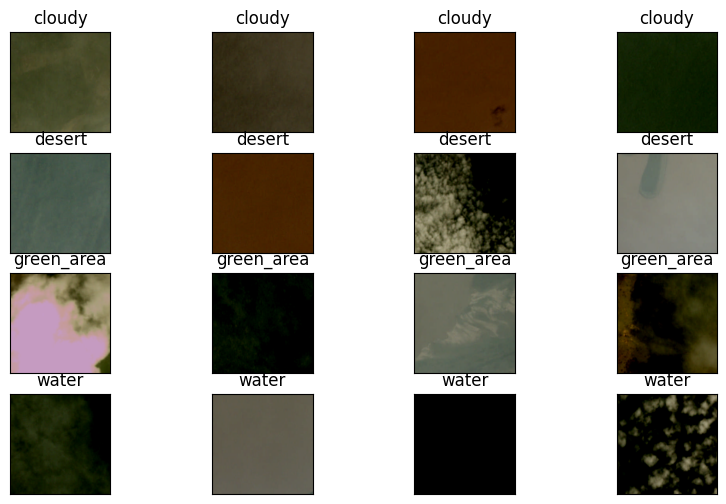

In [12]:
# Assuming train_data is your DataLoader object
# Create a figure object with a specific size
fig = plt.figure(figsize=(10, 6))  
# Adjust layout of subplots to fit within the figure
fig.tight_layout()  

# Define class names and the number of images to display per class
class_names = ['cloudy', 'desert', 'green_area', 'water']
# Display 4 images for each satellite image type
num_images_per_genre = 4  

# Initialize a dictionary to hold indices of images for each class
class_indices = {class_name: [] for class_name in class_names}

# Collect indices of images for each class
for i, (_, label) in enumerate(train_dataset):
    class_name = class_names[label]
    if len(class_indices[class_name]) < num_images_per_genre:
        class_indices[class_name].append(i)
    if all(len(indices) == num_images_per_genre for indices in class_indices.values()):
        break

# Display images
for i, class_name in enumerate(class_names):
    for j, index in enumerate(class_indices[class_name]):
        img, _ = train_dataset.dataset[index]
        # Rearrange dimensions from (3, 180, 180) to (180, 180, 3)
        img = img.permute(1, 2, 0)  

        # Add subplot for each image
        t = fig.add_subplot(len(class_names), num_images_per_genre, i*num_images_per_genre + j + 1)
         # Set title as genre name
        t.set_title(class_name) 
        t.axes.get_xaxis().set_visible(False)
        t.axes.get_yaxis().set_visible(False)
        # Display image in subplot
        plt.imshow(img)  

# Show the figure with all subplots
plt.show()  

### Define data loaders

We set up the data loaders.  
Every loader is designed to function with a certain subset of the dataset, whether for testing, validation, or training. 
While the 'val_loader' and 'test_loader' use the same batch size, they do not shuffle their datasets, which is a usual practice for validation and test data to maintain consistency throughout assessment. The 'train_loader' is set to a batch size of 32 and supports data shuffling to introduce unpredictability during training epochs. 
No additional processes are created for the purpose of loading data, as evidenced by the option 'num_workers' being set to 0 across all loaders. 
Configuring these loaders improves efficiency and makes it easier to train and evaluate models on various subsets.

In [13]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=0, shuffle=True)
val_loader = DataLoader(val_dataset,num_workers=0, batch_size=32)
test_loader = DataLoader(test_dataset,num_workers=0, batch_size=32)

In [14]:
print(f"Number of batches in training DataLoader: {len(train_loader)}")
print(f"Number of batches in validation DataLoader: {len(val_loader)}")
print(f"Number of batches in test DataLoader: {len(test_loader)}")

Number of batches in training DataLoader: 124
Number of batches in validation DataLoader: 36
Number of batches in test DataLoader: 18


In [15]:
# Print the size of the first batch from each DataLoader
for loader_name, loader in zip(["training", "validation", "test"], [train_loader, val_loader, test_loader]):
    print(f"\nSize of the first batch in {loader_name} DataLoader:")
    for images, labels in loader:
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)
        break


Size of the first batch in training DataLoader:
Images shape: torch.Size([32, 3, 180, 180])
Labels shape: torch.Size([32])

Size of the first batch in validation DataLoader:
Images shape: torch.Size([32, 3, 180, 180])
Labels shape: torch.Size([32])

Size of the first batch in test DataLoader:
Images shape: torch.Size([32, 3, 180, 180])
Labels shape: torch.Size([32])


This line of code determines whether to use a CPU or a GPU for PyTorch operations based on CUDA availability. It configures the device to 'cuda' for CUDA-enabled GPUs; otherwise, it defaults to 'cpu' for CPU-based processing.

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Function train_model

This function trains a certain model over a set amount of epochs using a loss function, optimizer, and training data loader. The training data stream is iterated over, the loss is determined, backpropagation is performed, and the model parameters are modified based on the optimizer's optimization technique inside each epoch. To assess the training's performance, the average loss is printed after each period.  

In [17]:
# Define training function
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item() * images.size(0)  # Accumulate the loss
        epoch_loss = running_loss / len(train_dataset)  # Calculate epoch loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")  # Print epoch loss

# Three architectures:
## 1. Convoluted Neural Network: CNN

### Class CNN

This code creates a neural network model named 'CNN' with PyTorch's 'nn.Module' class. 

The '__init__' function sets up the neural network's layers:
* 'fc1': A linear layer with input 'input_size' and output 'hidden_size1'.
* 'relu1': The ReLU activation function is applied after the first linear layer.
* 'fc2': A linear layer with input 'hidden_size1' and output 'hidden_size2'.
* 'relu2' denotes the ReLU activation function applied after the second linear layer.
* 'flatten': Use this layer to reshape the input tensor.
* 'fc3': Linear layer, input size 'hidden_size2', output size 'num_classes'.

The 'forward' method implements the neural network's forward pass.
* Reshape the input tensor (x) using 'view'.
* Pass the reshaped tensor through the linear layers ('fc1', 'fc2', 'fc3'), then apply ReLU activations ('relu1', 'relu2') after the first two linear layers.
  
This neural network design has two hidden layers with ReLU activations and a final output layer, making it appropriate for classification applications.  

In [17]:
class CNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(CNN, self).__init__()
        # Define the first fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_size1)
        # Define the ReLU activation function
        self.relu1 = nn.ReLU()
        # Define the second fully connected layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        # Define the ReLU activation function
        self.relu2 = nn.ReLU()
        # Flatten the input
        self.flatten = nn.Flatten()
        # Define the third fully connected layer
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

Now define the model parameters and print them.

In [18]:
# Define model parameters
input_size = 180 * 180 * 3
hidden_size1 = 256
hidden_size2 = 128
num_classes = len(dataset.classes)

In [19]:
print("Model Parameters:")
print("Input Size:", input_size)
print("Hidden Layer 1 Size:", hidden_size1)
print("Hidden Layer 2 Size:", hidden_size2)
print("Number of Classes:", num_classes)

Model Parameters:
Input Size: 97200
Hidden Layer 1 Size: 256
Hidden Layer 2 Size: 128
Number of Classes: 4


#### Training the model: 

Train the model for '50 epochs' and '100 epochs' separately. 

In [20]:
# Train CNN for 50 epochs
cnn_50epochs = CNN(input_size, hidden_size1, hidden_size2, num_classes).to(device)  # Instantiate the neural network
criterion = nn.CrossEntropyLoss()  # Define the loss function
optimizer = optim.Adam(cnn_50epochs.parameters(), lr=0.001)  # Define the optimizer
train_model(cnn_50epochs, criterion, optimizer, train_loader, num_epochs=50)  # Train the model for 50 epochs

Epoch [1/50], Loss: 2.2371
Epoch [2/50], Loss: 0.8437
Epoch [3/50], Loss: 0.6937
Epoch [4/50], Loss: 0.5343
Epoch [5/50], Loss: 0.4931
Epoch [6/50], Loss: 0.4052
Epoch [7/50], Loss: 0.3605
Epoch [8/50], Loss: 0.3618
Epoch [9/50], Loss: 0.3858
Epoch [10/50], Loss: 0.3531
Epoch [11/50], Loss: 0.3319
Epoch [12/50], Loss: 0.3670
Epoch [13/50], Loss: 0.3796
Epoch [14/50], Loss: 0.4376
Epoch [15/50], Loss: 0.3274
Epoch [16/50], Loss: 0.3275
Epoch [17/50], Loss: 0.2907
Epoch [18/50], Loss: 0.3099
Epoch [19/50], Loss: 0.2993
Epoch [20/50], Loss: 0.3031
Epoch [21/50], Loss: 0.2851
Epoch [22/50], Loss: 0.2781
Epoch [23/50], Loss: 0.2871
Epoch [24/50], Loss: 0.2768
Epoch [25/50], Loss: 0.3055
Epoch [26/50], Loss: 0.2727
Epoch [27/50], Loss: 0.2793
Epoch [28/50], Loss: 0.2676
Epoch [29/50], Loss: 0.2662
Epoch [30/50], Loss: 0.2712
Epoch [31/50], Loss: 0.3117
Epoch [32/50], Loss: 0.2667
Epoch [33/50], Loss: 0.2549
Epoch [34/50], Loss: 0.2903
Epoch [35/50], Loss: 0.2693
Epoch [36/50], Loss: 0.2862
E

In [21]:
# Train CNN for 100 epochs
cnn_100epochs = CNN(input_size, hidden_size1, hidden_size2, num_classes).to(device)
optimizer = optim.Adam(cnn_100epochs.parameters(), lr=0.001)
train_model(cnn_100epochs, criterion, optimizer, train_loader, num_epochs=100)

Epoch [1/100], Loss: 2.0066
Epoch [2/100], Loss: 0.8062
Epoch [3/100], Loss: 0.6132
Epoch [4/100], Loss: 0.6703
Epoch [5/100], Loss: 0.4224
Epoch [6/100], Loss: 0.4021
Epoch [7/100], Loss: 0.3681
Epoch [8/100], Loss: 0.3557
Epoch [9/100], Loss: 0.3301
Epoch [10/100], Loss: 0.3239
Epoch [11/100], Loss: 0.3137
Epoch [12/100], Loss: 0.3103
Epoch [13/100], Loss: 0.3031
Epoch [14/100], Loss: 0.3609
Epoch [15/100], Loss: 0.3601
Epoch [16/100], Loss: 0.2775
Epoch [17/100], Loss: 0.3455
Epoch [18/100], Loss: 0.3036
Epoch [19/100], Loss: 0.2930
Epoch [20/100], Loss: 0.2823
Epoch [21/100], Loss: 0.2844
Epoch [22/100], Loss: 0.2708
Epoch [23/100], Loss: 0.3103
Epoch [24/100], Loss: 0.3387
Epoch [25/100], Loss: 0.2562
Epoch [26/100], Loss: 0.2838
Epoch [27/100], Loss: 0.3123
Epoch [28/100], Loss: 0.3289
Epoch [29/100], Loss: 0.2880
Epoch [30/100], Loss: 0.2746
Epoch [31/100], Loss: 0.2925
Epoch [32/100], Loss: 0.2921
Epoch [33/100], Loss: 0.2721
Epoch [34/100], Loss: 0.2840
Epoch [35/100], Loss: 0

### Function evaluate_model

This function evaluates the performance of a certain model using a data loader that is given. It is then put into evaluation mode, and predictions are produced repeatedly for each data batch using the data loader. It calculates the model's prediction accuracy for the dataset's real labels. The model's accuracy on the specified dataset is returned.

This function is critical for evaluating the model's performance on unknown data while keeping the model's parameters constant.

In [18]:
# Define evaluation function
def evaluate_model(model, data_loader):
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get predicted labels
            total += labels.size(0)  # Accumulate total count of images
            correct += (predicted == labels).sum().item()  # Count correct predictions
    accuracy = correct / total  # Calculate accuracy
    return accuracy  # Return accuracy

#### Evaluation on Training set

Calculate the accuracy of CNN on the training set after 50 epochs and 100 epochs.

In [24]:
# Evaluate CNN on the training set after 50 epochs
train_accuracy_50epochs = evaluate_model(cnn_50epochs, train_loader)
print(f"Training Accuracy after 50 epochs: {train_accuracy_50epochs:.4f}")

Training Accuracy after 50 epochs: 0.8650


In [25]:
# Evaluate CNN on the training set after 100 epochs
train_accuracy_100epochs = evaluate_model(cnn_100epochs, train_loader)
print(f"Training Accuracy after 100 epochs: {train_accuracy_100epochs:.4f}")

Training Accuracy after 100 epochs: 0.8726


#### Validation

Validate CNN Model by calculating the accuracy of the model on the validation set.

In [26]:
# Validate CNN on the validation set after 50 epochs
val_accuracy_50epochs = evaluate_model(cnn_50epochs, val_loader)
print(f"Validation Accuracy after 50 epochs: {val_accuracy_50epochs:.4f}")

Validation Accuracy after 50 epochs: 0.8712


In [27]:
# Validate CNN on the validation set after 100 epochs
val_accuracy_100epochs = evaluate_model(cnn_100epochs, val_loader)
print(f"Validation Accuracy after 100 epochs: {val_accuracy_100epochs:.4f}")

Validation Accuracy after 100 epochs: 0.9014


#### Testing

Test the CNN Model on the test dataset.

In [28]:
# Test CNN on the test set after 50 epochs
test_accuracy_50epochs = evaluate_model(cnn_50epochs, test_loader)
print(f"Test Accuracy after 50 epochs: {test_accuracy_50epochs:.4f}")

Test Accuracy after 50 epochs: 0.8741


In [29]:
# Test CNN on the test set after 100 epochs
test_accuracy_100epochs = evaluate_model(cnn_100epochs, test_loader)
print(f"Test Accuracy after 100 epochs: {test_accuracy_100epochs:.4f}")

Test Accuracy after 100 epochs: 0.8670


### Function get_all_predictions

This function accepts predictions from a given model and loads them from a specified data loader, along with the corresponding ground truth labels. The model is put into evaluation mode, the data loader is iterated over, predictions are calculated for each batch of data, and the predictions and labels are appended to separate lists. Finally, these lists, containing all of the predictions and ground truth labels, are returned. For purposes of evaluation, this function may be used to produce predictions on a dataset and compare them to the actual labels.

In [19]:
def get_all_predictions(model, data_loader):
    all_predictions = []  # List to store all predicted labels
    all_targets = []      # List to store all true labels
    model.eval() 
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            all_predictions.extend(predicted.cpu().numpy())  # Extend list with predicted labels
            all_targets.extend(labels.cpu().numpy())  # Extend list with true labels
    return all_predictions, all_targets  # Return predictions and targets

#### Evaluation of all the results of CNN

##### 1. Create Confusion Matrix

Plot a Confusion matrix for 50 epochs and 100 epochs.

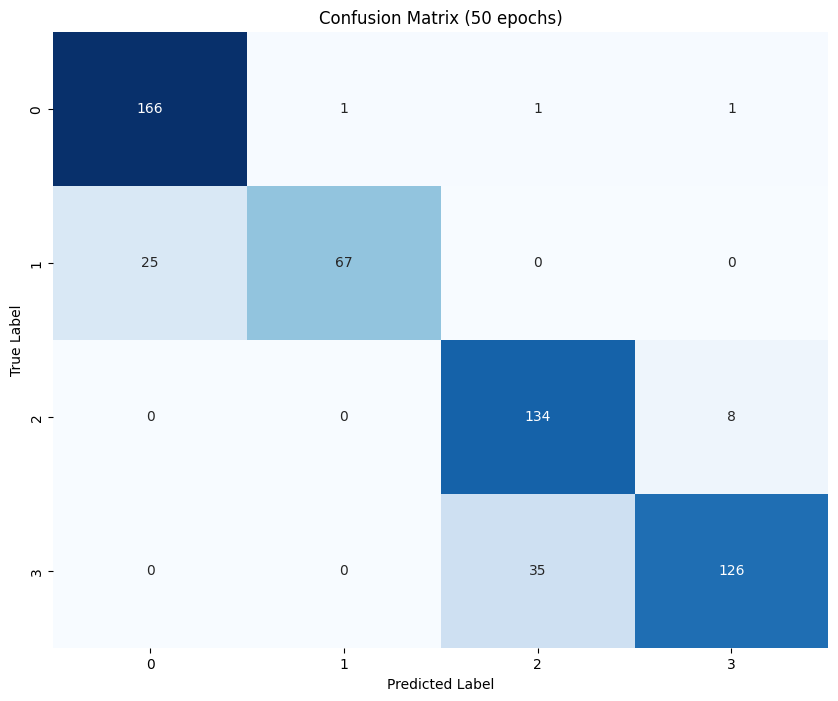

In [31]:
all_predictions, all_targets = get_all_predictions(cnn_50epochs, test_loader)

# Calculate confusion matrix
cm = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (50 epochs)')
plt.show()

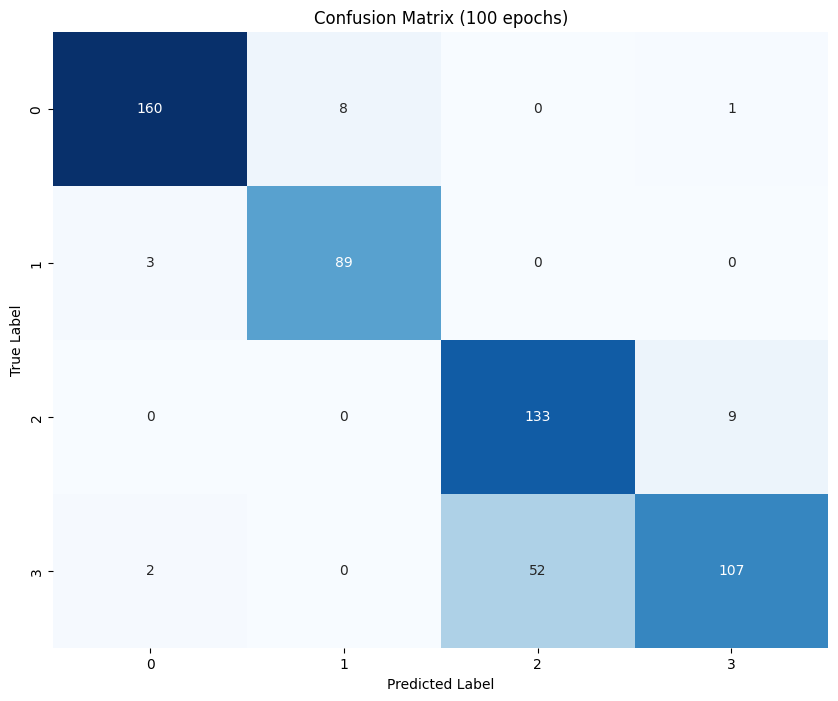

In [32]:
all_predictions_100epochs, all_targets_100epochs = get_all_predictions(cnn_100epochs, test_loader)

# Calculate confusion matrix for the model trained for 100 epochs
cm_100epochs = confusion_matrix(all_targets_100epochs, all_predictions_100epochs)

# Plot confusion matrix for the model trained for 100 epochs
plt.figure(figsize=(10, 8))
sns.heatmap(cm_100epochs, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (100 epochs)')
plt.show()

##### 2. Create the classification report

It computes precise evaluation metrics for each class in a multi-class classification task for 50 and 100 epochs.

In [33]:
# Calculate classification report for 50 epochs
report = classification_report(all_targets, all_predictions, target_names=class_names, zero_division=1)
print("Classification Report (50 epochs):")
print(report)

Classification Report (50 epochs):
              precision    recall  f1-score   support

      cloudy       0.87      0.98      0.92       169
      desert       0.99      0.73      0.84        92
  green_area       0.79      0.94      0.86       142
       water       0.93      0.78      0.85       161

    accuracy                           0.87       564
   macro avg       0.89      0.86      0.87       564
weighted avg       0.89      0.87      0.87       564



In [34]:
# Calculate classification report for the model trained for 100 epochs
report_100epochs = classification_report(all_targets_100epochs, all_predictions_100epochs, target_names=class_names, zero_division=1)
print("Classification Report (100 epochs):")
print(report_100epochs)

Classification Report (100 epochs):
              precision    recall  f1-score   support

      cloudy       0.97      0.95      0.96       169
      desert       0.92      0.97      0.94        92
  green_area       0.72      0.94      0.81       142
       water       0.91      0.66      0.77       161

    accuracy                           0.87       564
   macro avg       0.88      0.88      0.87       564
weighted avg       0.88      0.87      0.87       564



##### 3. Determine the precision, recall, and F1 score

For each class, compute the precision, recall, and F1-score across 100 epochs. Also, determine the total statistics.  

In [35]:
# Calculate precision, recall, and F1-score for each class
precision_per_class = precision_score(all_targets_100epochs, all_predictions_100epochs, average=None)
recall_per_class = recall_score(all_targets_100epochs, all_predictions_100epochs, average=None)
f1_per_class = f1_score(all_targets_100epochs, all_predictions_100epochs, average=None)

# Create a dictionary to store class-wise evaluation metrics
class_metrics = {
    "Class": class_names,
    "Precision": precision_per_class,
    "Recall": recall_per_class,
    "F1-score": f1_per_class
}

# Print class-wise evaluation metrics
class_metrics_df = pd.DataFrame(class_metrics)
print(class_metrics_df)

        Class  Precision    Recall  F1-score
0      cloudy   0.969697  0.946746  0.958084
1      desert   0.917526  0.967391  0.941799
2  green_area   0.718919  0.936620  0.813456
3       water   0.914530  0.664596  0.769784


In [36]:
# Calculate overall precision, recall, and F1-score
overall_precision = precision_score(all_targets_100epochs, all_predictions_100epochs, average='weighted')
overall_recall = recall_score(all_targets_100epochs, all_predictions_100epochs, average='weighted')
overall_f1 = f1_score(all_targets_100epochs, all_predictions_100epochs, average='weighted')

# Print overall evaluation metrics
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1)

Overall Precision: 0.8822995775507291
Overall Recall: 0.8670212765957447
Overall F1-score: 0.8652617472919306


##### 4. Plot the Precision-Recall curve

For each class, Plot the Precision-Recall curve for 100 epochs.

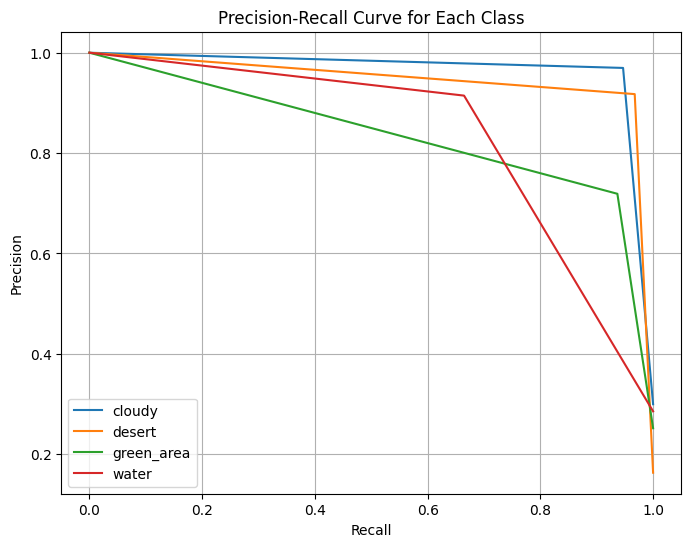

In [37]:
# Initialize empty lists to store precision and recall for each class
precision_per_class = []
recall_per_class = []

# Iterate over each class
for i in range(num_classes):
    # Treat the current class as positive, and all other classes as negative
    y_true_class = [1 if label == i else 0 for label in all_targets_100epochs]
    y_score_class = [1 if label == i else 0 for label in all_predictions_100epochs]

    # Compute precision and recall for the current class
    precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)

    # Append precision and recall to the lists
    precision_per_class.append(precision)
    recall_per_class.append(recall)

# Plot precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    class_name = class_names[i]
    plt.plot(recall_per_class[i], precision_per_class[i], label=f'{class_name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.grid(True)
plt.show()

##### 5. Calculate the area under the Precision-Recall curve.

For each class, Calculate the area under the Precision-Recall curve for 100 epochs.

In [38]:
# Initialize empty list to store area under curve for each class
auc_per_class = []

# Iterate over each class
for i in range(num_classes):
    # Treat the current class as positive, and all other classes as negative
    y_true_class = [1 if label == i else 0 for label in all_targets_100epochs]
    y_score_class = [1 if label == i else 0 for label in all_predictions_100epochs]

    # Compute precision and recall for the current class
    precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)

    # Calculate area under curve (AUC) for precision-recall curve of the current class
    auc_class = auc(recall, precision)

    # Append AUC to the list
    auc_per_class.append(auc_class)

In [39]:
# Print area under curve for each class
for i in range(num_classes):
    print(f"Class {i+1}: AUC = {auc_per_class[i]}")

Class 1: AUC = 0.9661999893178289
Class 2: AUC = 0.9451181132399362
Class 3: AUC = 0.8357480420186443
Class 4: AUC = 0.837435434336452


### Function calculate_classwise_accuracy
This approach compares predictions to ground truth labels to determine the accuracy of each class and evaluates a model's performance on a dataset. It totals the number of correct predictions and samples in each class. Finally, class-wise accuracy is calculated while considering sample-free conditions. This feature makes it easy to immediately assess the model's efficacy across multiple classes.  

In [20]:
def calculate_classwise_accuracy(model, data_loader, num_classes):
    model.eval()
    class_correct = [0] * num_classes  # List to store correct predictions for each class
    class_total = [0] * num_classes    # List to store total instances for each class

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get predicted labels
            for i in range(len(labels)):
                # Update correct predictions and total instances for each class
                class_correct[labels[i]] += (predicted[i] == labels[i]).item()
                class_total[labels[i]] += 1

    # Calculate class-wise accuracy
    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy  # Return class-wise accuracies

##### 6. Calculate class-wise accuracy.

For each class, Calculate class-wise accuracy for 100 epochs.

In [41]:
# Calculate class-wise accuracy
class_accuracy = cm_100epochs.diagonal() / cm_100epochs.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'cloudy' Accuracy: 0.9467
Class 'desert' Accuracy: 0.9674
Class 'green_area' Accuracy: 0.9366
Class 'water' Accuracy: 0.6646


## 2. ResNet-RNN
### Class RCNN

The given code creates a neural network model named "RCNN" with PyTorch's 'nn.Module' class. Here's an overview of the RCNN class:

Initialization: 
* The '__init__' function sets up the RCNN model. 
 * It begins by defining a backbone convolutional neural network (CNN) with numerous convolutional and pooling layers, most likely based on the ResNet architecture.
* It then establishes a Region Proposal Network (RPN) to generate regional proposals.
* Following that, it starts region-based ROI (Region of Interest) pooling, which pulls features from regions suggested by the RPN.
* Finally, it introduces completely linked layers for categorization.

Forward Pass: 
* The 'forward' approach passes the input picture data 'x' through the backbone CNN to extract features.
* These traits are then put into the RPN, which generates region suggestions.
* Next, region-based ROI pooling extracts features from the suggested areas.
* The retrieved features are flattened and routed through fully linked layers.
* ReLU activation occurs after the first completely linked layer.
* The output is sent via a softmax function along the dimension representing the classes, most likely for classification.

This type of architecture is widely used in object identification applications, notably in approaches such as Faster R-CNN (Region-based Convolutional Neural Network), which generates and classifies region proposals to find objects in an image. The ResNetBlock and RPN classes are defined within the RCNN class and contribute to the network's overall functioning by enabling residual connections and region proposal capabilities, respectively.
Also, define the model parameters.

In [17]:
class RCNN(nn.Module):
    def __init__(self, num_classes):
        super(RCNN, self).__init__()
        # Backbone CNN (e.g., ResNet)
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            ResNetBlock(64, 64),
            ResNetBlock(64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # Region Proposal Network (RPN)
        self.rpn = RPN(in_channels=64)
        # Region-based ROI Pooling
        self.roi_pooling = nn.AdaptiveMaxPool2d((7, 7))
        # Fully connected layers for classification
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Backbone CNN
        features = self.backbone(x)
        # Region Proposal Network (RPN)
        rpn_output = self.rpn(features)
        # Region-based ROI Pooling
        roi_features = self.roi_pooling(features)
        # Flatten ROI features
        roi_features = roi_features.view(roi_features.size(0), -1)
        # Fully connected layers
        x = F.relu(self.fc1(roi_features))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # Residual connection
        out = self.relu(out)
        return out

class RPN(nn.Module):
    def __init__(self, in_channels):
        super(RPN, self).__init__()
        self.conv = nn.Conv2d(in_channels, 256, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.cls_layer = nn.Conv2d(256, 2, kernel_size=1)  # Classification layer
        self.reg_layer = nn.Conv2d(256, 4, kernel_size=1)  # Regression layer

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        cls_output = self.cls_layer(x)
        reg_output = self.reg_layer(x)
        return cls_output, reg_output

In [18]:
learning_rate_rcnn = 0.001
batch_size = 32

#### Training the model: 

Train the model for '50 epochs' and '100 epochs' separately. 

In [21]:
# Train RCNN for 50 epochs
rcnn_50epochs = RCNN(num_classes).to(device)
optimizer = optim.Adam(rcnn_50epochs.parameters(), lr=learning_rate_rcnn)
criterion = nn.CrossEntropyLoss()
train_model(rcnn_50epochs, criterion, optimizer, train_loader, num_epochs=50)

Epoch [1/50], Loss: 0.5570
Epoch [2/50], Loss: 0.3310
Epoch [3/50], Loss: 0.3299
Epoch [4/50], Loss: 0.2746
Epoch [5/50], Loss: 0.2322
Epoch [6/50], Loss: 0.2484
Epoch [7/50], Loss: 0.2168
Epoch [8/50], Loss: 0.2604
Epoch [9/50], Loss: 0.2222
Epoch [10/50], Loss: 0.1999
Epoch [11/50], Loss: 0.1797
Epoch [12/50], Loss: 0.1492
Epoch [13/50], Loss: 0.1401
Epoch [14/50], Loss: 0.1303
Epoch [15/50], Loss: 0.1300
Epoch [16/50], Loss: 0.1132
Epoch [17/50], Loss: 0.1332
Epoch [18/50], Loss: 0.0770
Epoch [19/50], Loss: 0.1480
Epoch [20/50], Loss: 0.1153
Epoch [21/50], Loss: 0.0899
Epoch [22/50], Loss: 0.0892
Epoch [23/50], Loss: 0.0788
Epoch [24/50], Loss: 0.0766
Epoch [25/50], Loss: 0.0859
Epoch [26/50], Loss: 0.0887
Epoch [27/50], Loss: 0.0676
Epoch [28/50], Loss: 0.0591
Epoch [29/50], Loss: 0.0620
Epoch [30/50], Loss: 0.0662
Epoch [31/50], Loss: 0.0643
Epoch [32/50], Loss: 0.0490
Epoch [33/50], Loss: 0.0601
Epoch [34/50], Loss: 0.0521
Epoch [35/50], Loss: 0.0430
Epoch [36/50], Loss: 0.0513
E

In [21]:
# Train RCNN for 100 epochs
rcnn_100epochs = RCNN(num_classes).to(device)
optimizer = optim.Adam(rcnn_100epochs.parameters(), lr=learning_rate_rcnn)
train_model(rcnn_100epochs, criterion, optimizer, train_loader, num_epochs=100)

Epoch [1/100], Loss: 0.0352
Epoch [2/100], Loss: 0.0335
Epoch [3/100], Loss: 0.0242
Epoch [4/100], Loss: 0.0283
Epoch [5/100], Loss: 0.0294
Epoch [6/100], Loss: 0.0339
Epoch [7/100], Loss: 0.0282
Epoch [8/100], Loss: 0.0329
Epoch [9/100], Loss: 0.0497
Epoch [10/100], Loss: 0.0700
Epoch [11/100], Loss: 0.0295
Epoch [12/100], Loss: 0.0259
Epoch [13/100], Loss: 0.0284
Epoch [14/100], Loss: 0.0207
Epoch [15/100], Loss: 0.0246
Epoch [16/100], Loss: 0.0199
Epoch [17/100], Loss: 0.0197
Epoch [18/100], Loss: 0.0255
Epoch [19/100], Loss: 0.0205
Epoch [20/100], Loss: 0.0226
Epoch [21/100], Loss: 0.0281
Epoch [22/100], Loss: 0.0250
Epoch [23/100], Loss: 0.0350
Epoch [24/100], Loss: 0.0812
Epoch [25/100], Loss: 0.0298
Epoch [26/100], Loss: 0.0218
Epoch [27/100], Loss: 0.0253
Epoch [28/100], Loss: 0.0295
Epoch [29/100], Loss: 0.0332
Epoch [30/100], Loss: 0.0184
Epoch [31/100], Loss: 0.0386
Epoch [32/100], Loss: 0.0269
Epoch [33/100], Loss: 0.0263
Epoch [34/100], Loss: 0.0421
Epoch [35/100], Loss: 0

#### Evaluation on Training set

Calculate the accuracy of RCNN on the training set after 50 epochs and 100 epochs.

In [24]:
# Evaluate RCNN on the training set after 50 epochs
train_accuracy_rcnn_50epochs = evaluate_model(rcnn_50epochs, train_loader)
print(f"Training Accuracy after 50 epochs: {train_accuracy_rcnn_50epochs:.4f}")

Training Accuracy after 50 epochs: 0.9406


In [25]:
# Evaluate RCNN on the training set after 100 epochs
train_accuracy_rnn_100epochs = evaluate_model(rcnn_100epochs, train_loader)
print(f"Training Accuracy after 100 epochs: {train_accuracy_rnn_100epochs:.4f}")

Training Accuracy after 100 epochs: 0.9944


#### Validation

Validate RCNN Model by calculating the accuracy of the model on the validation set.

In [26]:
# Evaluate RCNN on the validation set after 50 epochs
val_accuracy_rcnn_50epochs = evaluate_model(rcnn_50epochs, val_loader)
print(f"Validation Accuracy after 50 epochs: {val_accuracy_rcnn_50epochs:.4f}")

Validation Accuracy after 50 epochs: 0.9369


In [27]:
# Evaluate RCNN on the validation set after 100 epochs
val_accuracy_rnn_100epochs = evaluate_model(rcnn_100epochs, val_loader)
print(f"Validation Accuracy after 100 epochs: {val_accuracy_rnn_100epochs:.4f}")

Validation Accuracy after 100 epochs: 0.9867


#### Testing

Test the RCNN Model on the test dataset.

In [28]:
# Evaluate RCNN on the test set after 50 epochs
test_accuracy_rcnn_50epochs = evaluate_model(rcnn_50epochs, test_loader)
print(f"Test Accuracy after 50 epochs: {test_accuracy_rcnn_50epochs:.4f}")

Test Accuracy after 50 epochs: 0.9557


In [29]:
# Evaluate RCNN on the test set after 100 epochs
test_accuracy_rnn_100epochs = evaluate_model(rcnn_100epochs, test_loader)
print(f"Test Accuracy after 100 epochs: {test_accuracy_rnn_100epochs:.4f}")

Test Accuracy after 100 epochs: 0.9929


#### Evaluation of all the results of RCNN

##### 1. Create Confusion Matrix

Plot a Confusion matrix for 50 epochs and 100 epochs.

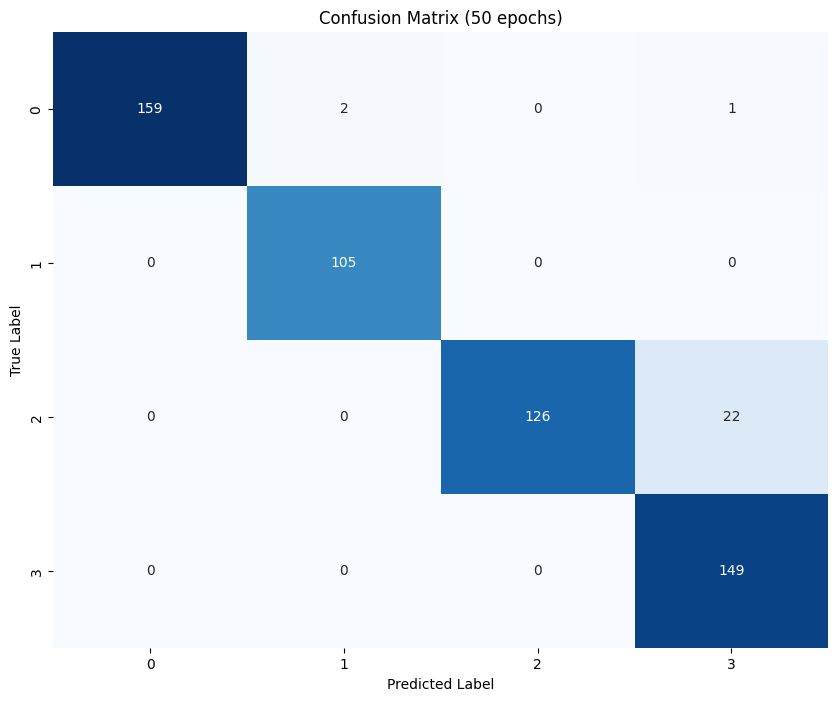

In [30]:
all_predictions, all_targets = get_all_predictions(rcnn_50epochs, test_loader)

# Calculate confusion matrix
cm = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (50 epochs)')
plt.show()

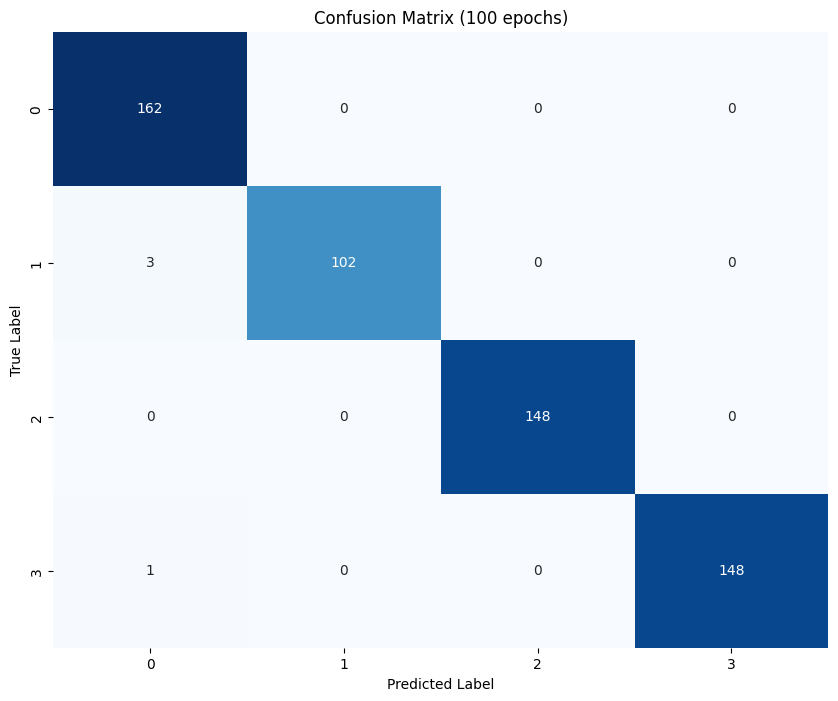

In [31]:
all_predictions_100epochs, all_targets_100epochs = get_all_predictions(rcnn_100epochs, test_loader)

# Calculate confusion matrix for the model trained for 100 epochs
cm_100epochs = confusion_matrix(all_targets_100epochs, all_predictions_100epochs)

# Plot confusion matrix for the model trained for 100 epochs
plt.figure(figsize=(10, 8))
sns.heatmap(cm_100epochs, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (100 epochs)')
plt.show()

##### 2. Generate the Classification report

It provides detailed evaluation metrics for each class in a multi-class classification problem for 50 and 100 epochs.

In [32]:
# Calculate classification report for 50 epochs
report = classification_report(all_targets, all_predictions, target_names=class_names, zero_division=1)
print("Classification Report (50 epochs):")
print(report)

Classification Report (50 epochs):
              precision    recall  f1-score   support

      cloudy       1.00      0.98      0.99       162
      desert       0.98      1.00      0.99       105
  green_area       1.00      0.85      0.92       148
       water       0.87      1.00      0.93       149

    accuracy                           0.96       564
   macro avg       0.96      0.96      0.96       564
weighted avg       0.96      0.96      0.96       564



In [33]:
# Calculate classification report for the model trained for 100 epochs
report_100epochs = classification_report(all_targets_100epochs, all_predictions_100epochs, target_names=class_names, zero_division=1)
print("Classification Report (100 epochs):")
print(report_100epochs)

Classification Report (100 epochs):
              precision    recall  f1-score   support

      cloudy       0.98      1.00      0.99       162
      desert       1.00      0.97      0.99       105
  green_area       1.00      1.00      1.00       148
       water       1.00      0.99      1.00       149

    accuracy                           0.99       564
   macro avg       0.99      0.99      0.99       564
weighted avg       0.99      0.99      0.99       564



##### 3. Calculate the Precision, Recall and F1-score

For each class, Calculate the Precision Recall and F1-score for 100 epochs. Also calculate the overall metrics.

In [34]:
# Calculate precision, recall, and F1-score for each class
precision_per_class = precision_score(all_targets_100epochs, all_predictions_100epochs, average=None)
recall_per_class = recall_score(all_targets_100epochs, all_predictions_100epochs, average=None)
f1_per_class = f1_score(all_targets_100epochs, all_predictions_100epochs, average=None)

# Create a dictionary to store class-wise evaluation metrics
class_metrics = {
    "Class": class_names,
    "Precision": precision_per_class,
    "Recall": recall_per_class,
    "F1-score": f1_per_class
}

# Print class-wise evaluation metrics
class_metrics_df = pd.DataFrame(class_metrics)
print(class_metrics_df)

        Class  Precision    Recall  F1-score
0      cloudy   0.975904  1.000000  0.987805
1      desert   1.000000  0.971429  0.985507
2  green_area   1.000000  1.000000  1.000000
3       water   1.000000  0.993289  0.996633


In [35]:
# Calculate overall precision, recall, and F1-score
overall_precision = precision_score(all_targets_100epochs, all_predictions_100epochs, average='weighted')
overall_recall = recall_score(all_targets_100epochs, all_predictions_100epochs, average='weighted')
overall_f1 = f1_score(all_targets_100epochs, all_predictions_100epochs, average='weighted')

# Print overall evaluation metrics
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1)

Overall Precision: 0.9930786977698027
Overall Recall: 0.9929078014184397
Overall F1-score: 0.9929095170421706


##### 4. Plot the Precision-Recall curve

For each class, Plot the Precision-Recall curve for 100 epochs.

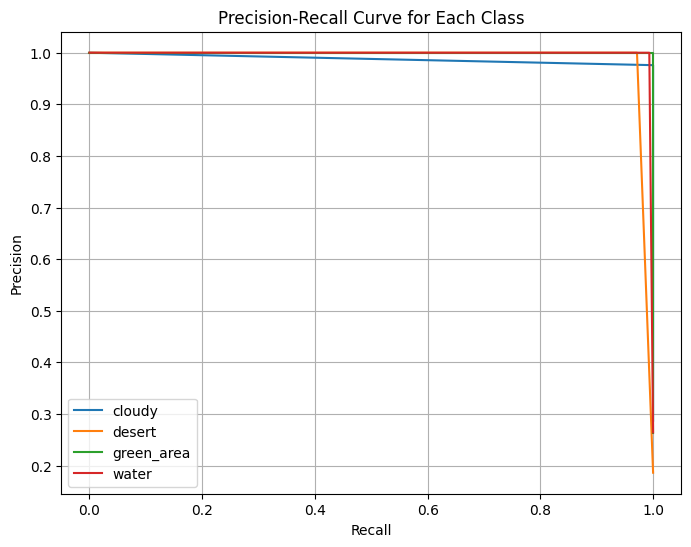

In [36]:
# Initialize empty lists to store precision and recall for each class
precision_per_class = []
recall_per_class = []

# Iterate over each class
for i in range(num_classes):
    # Treat the current class as positive, and all other classes as negative
    y_true_class = [1 if label == i else 0 for label in all_targets_100epochs]
    y_score_class = [1 if label == i else 0 for label in all_predictions_100epochs]

    # Compute precision and recall for the current class
    precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)

    # Append precision and recall to the lists
    precision_per_class.append(precision)
    recall_per_class.append(recall)

# Plot precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    class_name = class_names[i]
    plt.plot(recall_per_class[i], precision_per_class[i], label=f'{class_name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.grid(True)
plt.show()

##### 5. Calculate the area under the Precision-Recall curve.

For each class, Calculate the area under the Precision-Recall curve for 100 epochs.

In [37]:
# Initialize empty list to store area under curve for each class
auc_per_class = []

# Iterate over each class
for i in range(num_classes):
    # Treat the current class as positive, and all other classes as negative
    y_true_class = [1 if label == i else 0 for label in all_targets_100epochs]
    y_score_class = [1 if label == i else 0 for label in all_predictions_100epochs]

    # Compute precision and recall for the current class
    precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)

    # Calculate area under curve (AUC) for precision-recall curve of the current class
    auc_class = auc(recall, precision)

    # Append AUC to the list
    auc_per_class.append(auc_class)

In [38]:
# Print area under curve for each class
for i in range(num_classes):
    print(f"Class {i+1}: AUC = {auc_per_class[i]}")

Class 1: AUC = 0.9879518072289157
Class 2: AUC = 0.9883738601823708
Class 3: AUC = 1.0
Class 4: AUC = 0.9975308201247085


##### 6. Calculate class-wise accuracy.

For each class, Calculate class-wise accuracy for 100 epochs.

In [39]:
# Calculate class-wise accuracy
class_accuracy = cm_100epochs.diagonal() / cm_100epochs.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'cloudy' Accuracy: 1.0000
Class 'desert' Accuracy: 0.9714
Class 'green_area' Accuracy: 1.0000
Class 'water' Accuracy: 0.9933


## Architecture 3 is in notebook 'code2'